In [1]:
# Prevent preallocation of memory
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

import numpy as np
import matplotlib.pyplot as plt
import brainpy.math as bm
from Network_Multiple_Maps_wyl import Place_net, Grid_net
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

import os
import random

# Set random seed
seed = 3
np.random.seed(seed)
bm.random.seed(seed)
random.seed(seed)

/home/yulingwu/miniconda3/envs/CCS_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
z_min = 0
z_max = 20
place_num = 800
grid_num = 20
module_num = 10
map_num = 20
a_p = 0.5
Spacing = np.linspace(6,20,module_num)

Place_cell = Place_net(z_min=z_min, z_max=z_max, map_num=map_num, neuron_num=place_num, place_num=place_num, noise_stre=0.5)
maps = bm.as_numpy(Place_cell.map) 
place_index = bm.as_numpy(Place_cell.place_index) 


Gird_module_list = bm.NodeList([])
for module in range(module_num):
    Grid_cell = Grid_net(L = Spacing[module], maps=maps, place_index=place_index, neuron_num=grid_num, J0=5, a_g=a_p/Spacing[module]*2*bm.pi, W0=0.05)
    Gird_module_list.append(Grid_cell)

conn_out = Grid_cell.conn_out

100%|██████████| 20000/20000 [00:10<00:00, 1919.14it/s]


4
0.10832564532756805


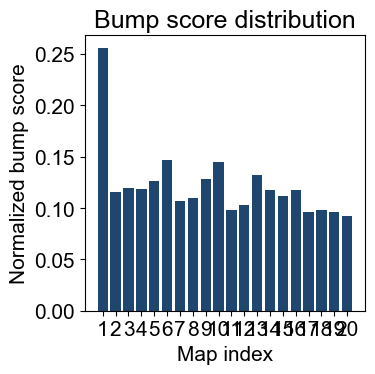

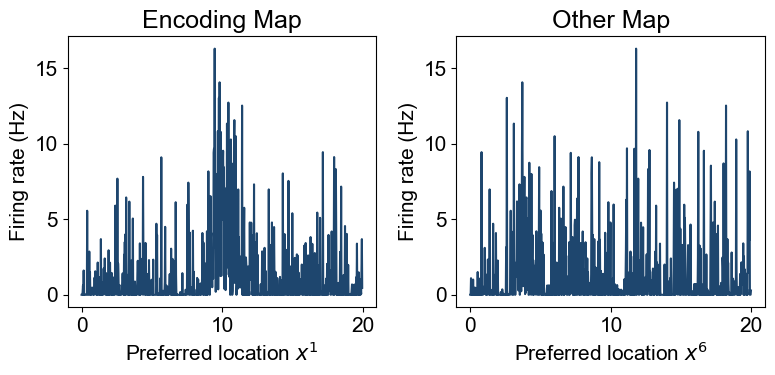

In [ ]:
z0 = 10
map_index = 0
I_per = 20 # Modified parameter

# Initialize the network
def initialize(indices, input_stre):
  output = bm.zeros(place_num,)
  for Grid_cell in Gird_module_list:
    Grid_cell.step_run(indices, r_hpc= I_per * Place_cell.r, loc=z0, input_stre=input_stre, map_index = map_index)
    output += Grid_cell.output
  Place_cell.step_run(indices, loc=z0, map_index = map_index, input_stre=input_stre, input_g = output * I_per)
  place_r = Place_cell.r
  return output, place_r

total_time = 20000
start_time = 1000
indices = bm.arange(total_time)
loc = bm.zeros(total_time) + (z_max+z_min)/2
input_stre = bm.zeros(total_time) 
input_stre[:start_time] = 10.
output, place_r = bm.for_loop(initialize, (indices, input_stre), progress_bar = True)

u = Place_cell.r
loc_num = 100
loc_candidate = np.linspace(z_min,z_max,loc_num,endpoint=False)
bump_score = np.zeros(map_num,)
max_score_pos = np.zeros(map_num,)
for map_index in range(map_num):
  u_place = bm.as_numpy(u[place_index[map_index]])
  score_candidate = np.zeros(loc_num,)
  for j in range(loc_num):
    bump = Place_cell.get_bump(map_index, loc_candidate[j])
    u_place = u_place/bm.sum(u_place)
    score_candidate[j] = bm.sum(bump*u_place)
    bump_score[map_index] = np.max(score_candidate)
  max_score_pos[map_index] = loc_candidate[np.argmax(score_candidate)]

plt.rcParams.update({'font.size': 15, 'font.family': 'Arial'})

plt.figure(figsize=(4,4))
plt.bar(np.arange(map_num)+1, bump_score, color=[30/255, 70/255, 110/255])
plt.xticks(np.arange(map_num)+1)
plt.xlabel('Map index')
plt.ylabel('Normalized bump score')
plt.title('Bump score distribution')
plt.tight_layout()
# plt.savefig('./figures/bump_score.pdf')

plt.rcParams.update({'font.size': 15, 'font.family': 'Arial'})


bump_score_other = bump_score[1:]
index = np.argmax(bump_score_other)
print(index)
print(bump_score[0]-bump_score_other[index])
# Plotting
_, ax = plt.subplots(1, 2, figsize=(2*4, 4))
for map_index in range(2):
  if map_index == 1:
    u_place = place_r[:, place_index[index+1]]
    sorted_indices = np.argsort(maps[index+1])
    sorted_maps = maps[index+1, sorted_indices]
    sorted_u_place = u_place[:, sorted_indices]
    ax[map_index].plot(sorted_maps, sorted_u_place[-1, :]*1000, color=[30/255, 70/255, 110/255])
    ax[map_index].set_title(f'Other Map')
    ax[map_index].set_xlabel(r'Preferred location $x^{' + str(index+1+1) + '}$')
    ax[map_index].set_ylabel('Firing rate (Hz)')
  else:
    u_place = place_r[:, place_index[map_index]]
    sorted_indices = np.argsort(maps[map_index])
    sorted_maps = maps[map_index, sorted_indices]
    sorted_u_place = u_place[:, sorted_indices]
    ax[map_index].plot(sorted_maps, sorted_u_place[-1, :]*1000, color=[30/255, 70/255, 110/255])
    ax[map_index].set_title(f'Encoding Map')
    ax[map_index].set_xlabel(r'Preferred location $x^{' + str(map_index+1) + '}$')
    ax[map_index].set_ylabel('Firing rate (Hz)')
plt.tight_layout()
# plt.savefig('figures/Bump_states.pdf')


In [ ]:
map_index = 0
recored_list = [[] for _ in range(len(Gird_module_list))]  # Initialize recored_list for each Grid_cell
timestep = 800
z = bm.linspace(0, 20, timestep)
integrate_step = bm.arange(timestep)


def step(integrate_step, I_per):
    
    def initialize(indices, input_stre):
        output = bm.zeros(place_num,)
        for Grid_cell in Gird_module_list:
            Grid_cell.step_run(indices, r_hpc= I_per * Place_cell.r, loc=z[integrate_step], input_stre=input_stre, map_index = map_index)
            output += Grid_cell.output
        Place_cell.step_run(indices, loc=z[integrate_step], map_index = map_index, input_stre=input_stre, input_g = output * I_per)
        place_r = Place_cell.r
        return output, place_r

    total_time = 20000
    start_time = 1000
    indices = bm.arange(total_time)
    input_stre = bm.zeros(total_time) 
    input_stre[:start_time] = 10.
    output, place_r = bm.for_loop(initialize, (indices, input_stre), progress_bar = True)
    return place_r[-1]

In [ ]:
I_per = bm.zeros(timestep) 
record_place_r_inactivated = bm.for_loop(step, (integrate_step, I_per), progress_bar=True)
# right：record_place_r_inactivated
u_place_couple = record_place_r_inactivated[:, place_index[map_index]]
sorted_u_place_couple = u_place_couple[:, sorted_indices]
sorted_u_place_inactivated = sorted_u_place_couple

np.savez('/home/yulingwu/CCS_place_grid_0710/Storing_multiple_maps/data/sorted_u_place_inactivated.npz',
        sorted_u_place_inactivated = sorted_u_place_inactivated)

100%|██████████| 800/800 [1:37:53<00:00,  7.34s/it]


In [ ]:
I_per[:] = 1
record_place_r = bm.for_loop(step, (integrate_step, I_per), progress_bar=True)

# left：record_place_r
u_place_active = record_place_r[:, place_index[map_index]]
sorted_indices = np.argsort(maps[map_index])
sorted_maps = maps[map_index, sorted_indices]
sorted_u_place_active = u_place_active[:, sorted_indices]

np.savez('/home/yulingwu/CCS_place_grid_0710/Storing_multiple_maps/data/sorted_u_place_control.npz',
        sorted_u_place_control = sorted_u_place_active)

100%|██████████| 800/800 [1:38:01<00:00,  7.35s/it]


In [ ]:
I_per[:] = 20
record_place_r_depolarized = bm.for_loop(step, (integrate_step, I_per), progress_bar=True)

# record_place_r_depolarized
u_place_depolarized = record_place_r_depolarized[:, place_index[map_index]]
sorted_u_place_depolarized = u_place_depolarized[:, sorted_indices]

np.savez('/home/yulingwu/CCS_place_grid_0710/Storing_multiple_maps/data/sorted_u_place_depolarized.npz',
        sorted_u_place_depolarized = sorted_u_place_depolarized)

100%|██████████| 800/800 [1:37:39<00:00,  7.32s/it]


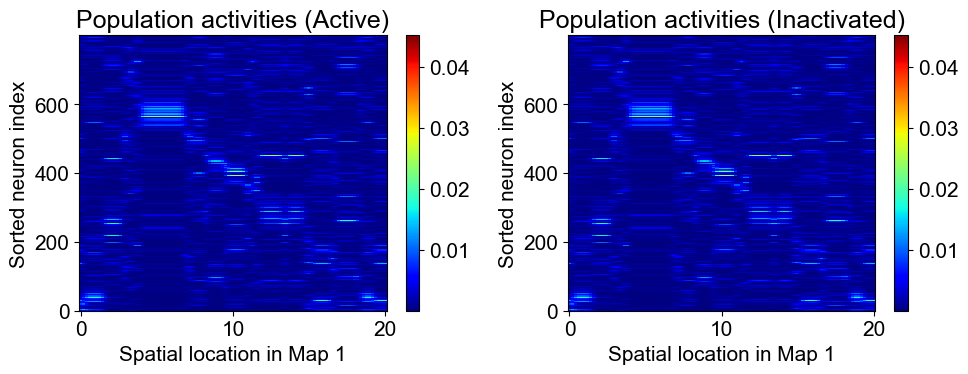

In [ ]:
from scipy.ndimage import gaussian_filter

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Left plot: record_place_r
u_place_active = record_place_r[:, place_index[map_index]]
sorted_indices = np.argsort(maps[map_index])
sorted_maps = maps[map_index, sorted_indices]
sorted_u_place_active = u_place_active[:, sorted_indices]
flipped_sorted_u_place_active = np.flipud(sorted_u_place_active.T)
top_10_percent_active = int(0.1 * flipped_sorted_u_place_active.max(axis=1).size)
top_values_active = np.sort(flipped_sorted_u_place_active.flatten())[-top_10_percent_active:]
vmax_active = top_values_active[0] if len(top_values_active) > 0 else flipped_sorted_u_place_active.max()

# Right plot: record_place_r_inactivated
u_place_couple = record_place_r_inactivated[:, place_index[map_index]]
sorted_u_place_couple = u_place_couple[:, sorted_indices]
sorted_u_place_inactivated = sorted_u_place_couple
flipped_sorted_u_place_couple = np.flipud(sorted_u_place_couple.T)
top_10_percent_couple = int(0.1 * flipped_sorted_u_place_couple.max(axis=1).size)
top_values_couple = np.sort(flipped_sorted_u_place_couple.flatten())[-top_10_percent_couple:]
vmax_couple = top_values_couple[0] if len(top_values_couple) > 0 else flipped_sorted_u_place_couple.max()

# record_place_r_depolarized
u_place_depolarized = record_place_r_depolarized[:, place_index[map_index]]
sorted_u_place_depolarized = u_place_depolarized[:, sorted_indices]

# Apply Gaussian smoothing to the data
smoothed_active = gaussian_filter(flipped_sorted_u_place_active, sigma=1)
smoothed_couple = gaussian_filter(flipped_sorted_u_place_couple, sigma=1)

pcm1 = ax[0].pcolormesh(z, np.arange(place_num), smoothed_active, cmap='jet', vmax=vmax_couple)
fig.colorbar(pcm1, ax=ax[0])
ax[0].set_xlabel('Spatial location in Map 1')
ax[0].set_ylabel('Sorted neuron index')
ax[0].set_title('Population activities (Active)')

pcm2 = ax[1].pcolormesh(z, np.arange(place_num), smoothed_couple, cmap='jet', vmax=vmax_couple)
fig.colorbar(pcm2, ax=ax[1])
ax[1].set_xlabel('Spatial location in Map 1')
ax[1].set_ylabel('Sorted neuron index')
ax[1].set_title('Population activities (Inactivated)')

plt.tight_layout()
plt.show()